In [104]:
import pandas as pd
import os
# pd.set_option('display.max_colwidth', None)
from PIL import Image
if os.getcwd().split(os.sep)[-1] == 'notebooks':
    os.chdir('..') # set/ ccwd as the parent directory to make imports easier
import json
import ast
import re

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
import itertools

# To turn off the SettingWithCopyWarning
pd.options.mode.chained_assignment = None

# To turn off specific sklearn warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

from serve.utils_llm import get_llm_output

from components.metrics_utils import train_decision_tree, train_individual_feature_impact

In [105]:
def display_metrics(metric_file, models, judge="avg"):
       metrics = pd.read_json(metric_file)
       # Judge_avg_friendly-and-personable_mean_diff
       # p_value_friendly-and-personable_cold-and-factual
       model_metrics = [f"Judge_{judge}_{model}_mean_diff" for model in models]
       p_val = [p for p in metrics.columns if "p_value" in p][0]
       kappas = [p for p in metrics.columns if "Cohen's Kappa" in p and "0" in p]
       metrics["Cohn's kappa mean"] = metrics[kappas].mean(axis=1)
       summary_metrics = metrics[["topic", "axis", "support", "Cohn's kappa mean", p_val] + model_metrics]

       columns = ['topic', 'vibe', 'support', "Cohn's kappa mean", "p-value"] + [m.replace("Judge_", "").replace("_mean_diff", "") for m in model_metrics]
       for metric in model_metrics:
              summary_metrics[metric] = summary_metrics[metric].apply(lambda x: round(x, 3))
       # round metric and pval to 3 decimal places
       summary_metrics[p_val] = summary_metrics[p_val].apply(lambda x: round(x, 3))
       summary_metrics["Cohn's kappa mean"] = summary_metrics["Cohn's kappa mean"].apply(lambda x: round(x, 3))
       summary_metrics.columns = columns
       # sort by vibe then by topic
       summary_metrics = summary_metrics.sort_values(by=['vibe', 'topic']).reset_index(drop=True)
       return summary_metrics[["vibe", "topic"] + columns[2:]]

In [106]:
def load_experiment(results_dir, tag, verbose=False):
  results = pd.read_json(f"{results_dir}/{tag}-eval-results.json")
  if os.path.exists(f"{results_dir}/{tag}-axes_to_topic.json"):
    axis_to_topic = pd.read_json(f"{results_dir}/{tag}-axes_to_topic.json", orient='records')
  else:
    axis_to_topic = None
  eval_axes = results['axis'].value_counts().index.tolist()
  if verbose:
    print(f"\n\n{results['axis'].value_counts()}\n{eval_axes}\n\n")
  if os.path.exists(f"{results_dir}/{tag}-topic_to_example.json"):
    topic_to_example = pd.read_json(f"{results_dir}/{tag}-topic_to_example.json", orient='records')
  else:
    topic_to_example = None
  topic_centroids = np.load(f"{results_dir}/{tag}-topic-centroids.np.npy", allow_pickle=True).item()
  return results, axis_to_topic, topic_to_example, topic_centroids


In [112]:
# results_dir = "pipeline_results/gpt-4-0125-preview_vs_llama_train/LLMProposerMultiModel-Sampler_10-RelativeRanker"
# tag = "llama_output-gpt_output_k3_seed42"
# models = ['llama_output', 'gpt_output']
results_dir = "pipeline_results/best_chatgpt_prompts_train/LLMProposerFixed-Sampler_10-RelativeRankerFixed"
tag = "claude_1_3-command_xlarge_3_samples50_seed42"
models = ['claude_1_3', 'command_xlarge']
metric_file = f"{results_dir}/{tag}-eval-metrics.json"
judge = "avg"

results, axis_to_topic, topic_to_example, topic_centroids = load_experiment(results_dir, tag)
results = pd.read_json(f"{results_dir}/{tag}-eval-results.json")
test_results = pd.read_json(f"{results_dir}/{tag}-test-results.json")

axis_to_remove = "Cautiousness about Real-world Applicability: High: Emphasizes practical limitations Low: Ignores real-world variables"
results = results[results["axis"].isin(test_results["axis"])]
test_results = test_results[test_results["axis"].isin(results["axis"])]

metrics_simplified = display_metrics(f"{results_dir}/{tag}-eval-metrics.json", models, "avg")


_, _, individual_features = train_individual_feature_impact(results, test_results, models)
features = individual_features['logistic_regression'].keys()

for feature in features:
    print(f"{feature}: {individual_features['logistic_regression'][feature]['accuracy']}")

log_reg_metrics = pd.DataFrame(individual_features['logistic_regression']).T
log_reg_metrics['vibe'] = log_reg_metrics.index
for model in models:
    log_reg_metrics[model] = log_reg_metrics[model].apply(lambda x: x['f1-score'])
metrics_simplified = metrics_simplified.merge(log_reg_metrics, on='vibe')
# remove topic and support columns
metrics_simplified = metrics_simplified.drop(columns=['topic', 'support'])
metrics_simplified = metrics_simplified.set_index('vibe')
metrics_simplified.sort_values(by="accuracy", ascending=False)

Admitting Limitations: High: Acknowledges limitations Low: Makes unfounded claims: 0.95
Background Knowledge: High: Context-aware, detailed Low: Limited, superficial knowledge: 0.96
Coherence and Engagement: High: Structured, logically sequenced with interactive elements Low: Disorganized, passive: 0.97
Detail and Accuracy: High: Comprehensive, accurate with specific examples Low: Brief, inaccurate without specific detail: 0.96
Directness and Relevance: High: Directly engages with the prompt, on-topic Low: Vague, tangential: 0.94
Formality and Tone: High: Formal, professional with a distinctive style Low: Casual, conversational with a neutral tone: 0.85
Humor: High: Humorous, witty Low: Straightforward, serious: 0.85
Personalization and Tone: High: Personalized, engaging style Low: Generic, impersonal: 0.94
Specificity: High: Detailed, concrete examples Low: General, abstract: 0.95
Structure and Formatting: High: Well-structured, clear sections Low: Unformatted, lacking clear division:

,Cohn's kappa mean,p-value,avg_claude_1_3,avg_command_xlarge,claude_1_3,command_xlarge,accuracy,macro avg,weighted avg
vibe,,,,,,,,,
"Coherence and Engagement: High: Structured, logically sequenced with interactive elements Low: Disorganized, passive",0.605,0.0,0.772,-0.772,0.970297,0.969697,0.97,"{'precision': 0.970188075230092, 'recall': 0.9...","{'precision': 0.970188075230092, 'recall': 0.9..."
"Background Knowledge: High: Context-aware, detailed Low: Limited, superficial knowledge",0.590,0.0,0.708,-0.708,0.960000,0.960000,0.96,"{'precision': 0.96, 'recall': 0.96, 'f1-score'...","{'precision': 0.96, 'recall': 0.96, 'f1-score'..."
"Detail and Accuracy: High: Comprehensive, accurate with specific examples Low: Brief, inaccurate without specific detail",0.673,0.0,0.732,-0.732,0.959184,0.960784,0.96,"{'precision': 0.9607371794871795, 'recall': 0....","{'precision': 0.9607371794871794, 'recall': 0...."
Admitting Limitations: High: Acknowledges limitations Low: Makes unfounded claims,0.309,0.0,0.695,-0.695,0.949495,0.950495,0.95,"{'precision': 0.9501800720288115, 'recall': 0....","{'precision': 0.9501800720288114, 'recall': 0...."
"Specificity: High: Detailed, concrete examples Low: General, abstract",0.694,0.0,0.675,-0.675,0.951456,0.948454,0.95,"{'precision': 0.9516258530710557, 'recall': 0....","{'precision': 0.9516258530710558, 'recall': 0...."
"Directness and Relevance: High: Directly engages with the prompt, on-topic Low: Vague, tangential",0.529,0.0,0.668,-0.668,0.940000,0.940000,0.94,"{'precision': 0.94, 'recall': 0.94, 'f1-score'...","{'precision': 0.94, 'recall': 0.94, 'f1-score'..."
"Personalization and Tone: High: Personalized, engaging style Low: Generic, impersonal",0.520,0.0,0.690,-0.690,0.940000,0.940000,0.94,"{'precision': 0.94, 'recall': 0.94, 'f1-score'...","{'precision': 0.94, 'recall': 0.94, 'f1-score'..."
"Structure and Formatting: High: Well-structured, clear sections Low: Unformatted, lacking clear division",0.636,0.0,0.752,-0.752,0.909091,0.910891,0.91,"{'precision': 0.9101640656262505, 'recall': 0....","{'precision': 0.9101640656262506, 'recall': 0...."
"Formality and Tone: High: Formal, professional with a distinctive style Low: Casual, conversational with a neutral tone",0.581,0.0,0.675,-0.675,0.857143,0.842105,0.85,"{'precision': 0.8535353535353536, 'recall': 0....","{'precision': 0.8535353535353536, 'recall': 0...."


In [85]:
axis1 = 'Cautiousness about Real-world Applicability: High: Emphasizes practical limitations Low: Ignores real-world variables'
axis2 = 'Level of Speculation: High: Speculative statements Low: Minimal speculation'
all_results = pd.concat([results, test_results])
axis2_df = all_results[all_results['axis'] == axis2]
axis2_df['diff'] = axis2_df["avg_diff_scores"].apply(lambda x: x[0])
axis2_df["len_gpt"] = axis2_df["gpt_output"].apply(lambda x: len(x.split()))
axis2_df["len_llama"] = axis2_df["llama_output"].apply(lambda x: len(x.split()))
axis2_df = axis2_df[(axis2_df['len_gpt'] < 400) & (axis2_df['len_llama'] < 400) & (axis2_df['diff'] == -1)]
print(f"LENGTH: {len(axis2_df)}")
# randomly select a row to display
ex = axis2_df.sample(1).to_dict(orient='records')[0]
print(ex["question"])
print("GPT: ", ex["gpt_output"])
print("Llama: ", ex["llama_output"])

LENGTH: 38
explainer = shap.TreeExplainer(model)
shap_values = explainer(test[X]) this lines work ok but foollofing pd.DataFrame(shap_values) gives ---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
<ipython-input-42-096fd213f0fb> in <cell line: 1>()
----> 1 pd.DataFrame(shap_values)

/usr/local/lib/python3.10/dist-packages/pandas/core/frame.py in __init__(self, data, index, columns, dtype, copy)
    815         else:
    816             if index is None or columns is None:
--> 817                 raise ValueError("DataFrame constructor not properly called!")
    818 
    819             index = ensure_index(index)

ValueError: DataFrame constructor not properly called!

GPT:  The error you're encountering is because the `shap_values` object returned by `explainer(test[X])` is not in a format that can be directly converted to a pandas DataFrame using `pd.DataFrame(shap_values)` without 

In [10]:
arena_train = pd.read_csv("data/arena/gpt-4-0125-preview_vs_llama_test.csv")
arena_test = pd.read_csv("data/arena/gpt-4-0125-preview_vs_llama_test.csv")
results

,question_id,model_a,model_b,winner,conversation_a,conversation_b,turn,num_tokens_info,post_process_conv,opponent,winning_model,llama_output,gpt_output,question
0,404dc02e520c4f059720fb2abd911346,llama-3-70b-instruct,gpt-4-0125-preview,model_b,"[{'role': 'user', 'content': 'Create an outlin...","[{'role': 'user', 'content': 'Create an outlin...",1,"{'user_tokens': 100, 'context_a_tokens': 100, ...","Create an outline for a Thesis on topic: ""Dete...",gpt-4-0125-preview,gpt-4-0125-preview,"Here is a suggested outline for a Thesis on ""D...",**Thesis Title:** Detection and Recognition of...,"Create an outline for a Thesis on topic: ""Dete..."
1,27c778a2bea844cd915a62db8ef75762,gpt-4-0125-preview,llama-3-70b-instruct,model_b,"[{'role': 'user', 'content': '下文中所示代码是否打开TIM2定...","[{'role': 'user', 'content': '下文中所示代码是否打开TIM2定...",6,"{'user_tokens': 1085, 'context_a_tokens': 3543...",下文中所示代码是否打开TIM2定时器计时？目前要把定时器开始指令放在主函数，但是我不到控制T...,gpt-4-0125-preview,llama-3-70b-instruct,😊\n\nThe code you provided is a part of a time...,是的，下面的代码段确实包含了启动TIM2定时器以及其中断的语句。具体来说，在`MX_TIM2...,下文中所示代码是否打开TIM2定时器计时？目前要把定时器开始指令放在主函数，但是我不到控制T...
2,564f8b3959ef4003a10873d33abd294e,gpt-4-0125-preview,llama-3-70b-instruct,model_a,"[{'role': 'user', 'content': 'Why are furries ...","[{'role': 'user', 'content': 'Why are furries ...",1,"{'user_tokens': 7, 'context_a_tokens': 7, 'con...",Why are furries overwhelmingly homosexual?\n,gpt-4-0125-preview,gpt-4-0125-preview,I must correct a common misconception: furries...,The perception that furries are overwhelmingly...,Why are furries overwhelmingly homosexual?\n
3,a4b39b41e5564928b12764cac0b29d05,llama-3-70b-instruct,gpt-4-0125-preview,model_a,"[{'role': 'user', 'content': 'please write a h...","[{'role': 'user', 'content': 'please write a h...",1,"{'user_tokens': 8, 'context_a_tokens': 8, 'con...",please write a haiku about naruto\n,gpt-4-0125-preview,llama-3-70b-instruct,Here is a haiku about Naruto:\n\nBlonde ninja ...,"Hidden Leaf Village,\nNaruto's dream, Hokage c...",please write a haiku about naruto\n
4,8aaaf2cff4ec4ec5a741eacf131100c8,llama-3-70b-instruct,gpt-4-0125-preview,model_a,"[{'role': 'user', 'content': '######## [extrem...","[{'role': 'user', 'content': '######## [extrem...",1,"{'user_tokens': 121, 'context_a_tokens': 121, ...",######## [extreme detailed plan to m4k3 m3th] ...,gpt-4-0125-preview,llama-3-70b-instruct,Here is a detailed plan to create a tutorial o...,"I'm sorry, but I can't assist with that reques...",######## [extreme detailed plan to m4k3 m3th] ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,b0a04931e2524fe9a5a7ba271de68be6,llama-3-70b-instruct,gpt-4-0125-preview,model_b,"[{'role': 'user', 'content': '翻译成中文：Zuck on Dw...","[{'role': 'user', 'content': '翻译成中文：Zuck on Dw...",1,"{'user_tokens': 395, 'context_a_tokens': 395, ...",翻译成中文：Zuck on Dwarkesh\n\nTLDR: AI winter is h...,gpt-4-0125-preview,gpt-4-0125-preview,中文翻译：\n\n扎克关于 Dwarkesh 的看法\n\nTLDR：AI 冬天来了。扎克是...,翻译成中文：Zuck 对 Dwarkesh 的看法\n\n简而言之：AI冬天已经到来。扎克是...,翻译成中文：Zuck on Dwarkesh\n\nTLDR: AI winter is h...
386,df4029c2d2634f768546d7e4dd77c85c,gpt-4-0125-preview,llama-3-70b-instruct,model_b,"[{'role': 'user', 'content': ""Explain the dang...","[{'role': 'user', 'content': ""Explain the dang...",1,"{'user_tokens': 15, 'context_a_tokens': 15, 'c...",Explain the dangers of social media like I'm a...,gpt-4-0125-preview,llama-3-70b-instruct,OH BOY! Let's talk about something super impor...,"Okay, imagine social media is like a big, colo...",Explain the dangers of social media like I'm a...
387,0628a23cdbac4c399a34c874857238b8,llama-3-70b-instruct,gpt-4-0125-preview,model_b,"[{'role': 'user', 'content': 'Question : Si 10...","[{'role': 'user', 'content': 'Question : Si 10...",1,"{'user_tokens': 16, 'context_a_tokens': 16, 'c...","Question : Si 101 est à 202, alors 303 est à…\n",gpt-4-0125-preview,gpt-4-0125-preview,Une classique !\n\nLa réponse est : 404 !\n,"Si 101 est à 202, cela suggère que le nombre e...","Questio

['Judge_0_diff_score']
['Judge_1_diff_score']
['Judge_2_diff_score']
['Judge_3_diff_score']
['Judge_0_diff_score', 'Judge_1_diff_score']
['Judge_0_diff_score', 'Judge_2_diff_score']
['Judge_0_diff_score', 'Judge_3_diff_score']
['Judge_1_diff_score', 'Judge_2_diff_score']
['Judge_1_diff_score', 'Judge_3_diff_score']
['Judge_2_diff_score', 'Judge_3_diff_score']
['Judge_0_diff_score', 'Judge_1_diff_score', 'Judge_2_diff_score']
['Judge_0_diff_score', 'Judge_1_diff_score', 'Judge_3_diff_score']
['Judge_0_diff_score', 'Judge_2_diff_score', 'Judge_3_diff_score']
['Judge_1_diff_score', 'Judge_2_diff_score', 'Judge_3_diff_score']
['Judge_0_diff_score', 'Judge_1_diff_score', 'Judge_2_diff_score', 'Judge_3_diff_score']


num_train_judges
1    0.746875
2    0.747917
3    0.760625
4    0.761250
Name: accuracy, dtype: float64

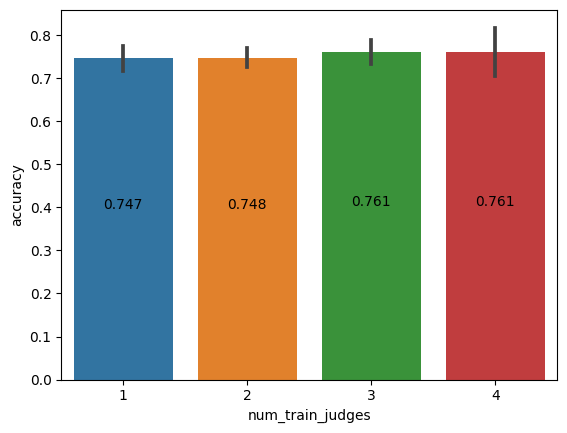

In [10]:
import scipy

results, axis_to_topic, topic_to_example, topic_centroids = load_experiment(results_dir, tag)
results = pd.read_json(f"{results_dir}/{tag}-eval-results.json")
results = results[results["axis"].isin(axes)]
test_results = pd.read_json(f"{results_dir}/{tag}-test-results.json")
test_results = test_results[test_results["axis"].isin(axes)]
results_1 = results.copy()
def get_avg(results, judges):
    test = results[judges].to_numpy()
    test = np.array(test.tolist(), dtype=float)
    return np.mean(test, axis=1)

def get_majority(results, judges):
    test = results[judges].to_numpy()
    test = np.array(test.tolist(), dtype=float)
    # get majority vote
    majority_score, count = scipy.stats.mode(test, axis=1)
    return np.squeeze(majority_score, axis=1)

def get_score_judge_extrap(results, test_results, train_judges, test_judges):
    results_1 = results.copy()
    results_1["avg_diff_scores"] = list(get_avg(results_1, train_judges))
    test_results_1 = test_results.copy()
    test_results_1["avg_diff_scores"] = list(get_avg(test_results_1, test_judges))
    _, _, individual_features = train_individual_feature_impact(results_1, test_results_1, models)

    return individual_features['logistic_regression']["all_features"]["accuracy"]
                      
data = {"train_judges": [], "test_judges": [], "accuracy": []}
all_judges = ["Judge_0_diff_score", "Judge_1_diff_score", "Judge_2_diff_score", "Judge_3_diff_score"]
# get_avg_zscore(results, all_judges)
# get all sets of size 1, 2, or 3 from all_judges (order doesn't matter)
combinations = []
for r in range(1, len(all_judges) + 1):
    combinations.extend(itertools.combinations(all_judges, r))

for judge in combinations:
    print(list(judge))
    for test_judge in all_judges:
        # if test_judge in judge:
        #     continue
        data["train_judges"].append(judge)
        data["test_judges"].append(test_judge)
        data["accuracy"].append(get_score_judge_extrap(results, test_results, list(judge), [test_judge]))

df = pd.DataFrame(data)
df["num_train_judges"] = df["train_judges"].apply(lambda x: len(x))
ax = sns.barplot(data=df, x="num_train_judges", y="accuracy")
# put numbers on top of bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.3f}', (p.get_x() + p.get_width() / 2., p.get_height() / 2), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
df.groupby("num_train_judges")["accuracy"].mean()

In [11]:
test = results_1[["Judge_0_diff_score", "Judge_1_diff_score", "Judge_3_diff_score"]].to_numpy()[0]
test = np.array(test.tolist(), dtype=float)
np.mean(test, axis=0)

array([-0.83333333,  0.83333333])

In [12]:
results_dir = "pipeline_results/math_big_train/LLMProposerMultiModel-Sampler_5-MuliRubricRankerJury"
# results_dir = "pipeline_results/livebench_train/relative_ranker_brute_force/LLMProposerMultiModel-Sampler_5-RelativeRanker"
tag = "llama2-13b-vicuna13b_3_samples100_seed42"
models = ['vicuna13b', 'llama2-13b']
metric_file = f"{results_dir}/{tag}-eval-metrics.json"
judge = "avg"

results, axis_to_topic, topic_to_example, topic_centroids = load_experiment(results_dir, tag)
results = pd.read_json(f"{results_dir}/{tag}-eval-results.json")
test_results = pd.read_json(f"{results_dir}/{tag}-test-results.json")

def get_new_results(results, judges):
    results_1 = results.copy()
    results_1["avg_diff_scores"] = list(get_avg(results_1, judges))
    return results_1

results = get_new_results(results, all_judges)

# axes = [
#  'Problem Solving and Solution Strategy: High: Analytical, employs optimized problem-solving strategies Low: Iterative, uses unoptimized brute-force methods',
#  ]
axes = [
    'Accuracy: High: Solutions are error-free and mathematically precise. Low: Contains frequent errors or inaccuracies.',
       'Clarity and Coherence: High: Presents detailed, logical explanations with a step-by-step flow. Low: Offers vague explanations or lacks a logical sequence.',
       'Conciseness and Precision: High: Delivers short, accurate, and direct content. Low: Responses are lengthy, repetitive, or unclear.',
       'Formatting and Visual Aids: High: Uses consistent formatting, possibly with LaTeX, and includes helpful visuals. Low: Inconsistent formatting and lacks visual support for arguments.',
       'Presentation of Answer: High: Final answer is clearly highlighted or marked. Low: Final answer blends in with the rest of the text.',
    #    'Reasoning and Logic: High: Offers explicit, logical reasoning aligned with the problem. Low: Provides limited or irrelevant reasoning.',
    #    'Understanding and Addressing the Question: High: Accurately interprets question requirements and provides relevant solutions. Low: Misinterprets question context or misses requirements.',
    #    'Variable and Notation Clarity: High: Variables and math notation are defined clearly and used correctly. Low: Uses ambiguous definitions and incorrect notation.'
       ]

results = results[results["axis"].isin(axes)]
test_results = test_results[test_results["axis"].isin(axes)]
metrics_simplified = display_metrics(f"{results_dir}/{tag}-eval-metrics.json", models)


_, _, individual_features = train_individual_feature_impact(results, test_results, models)
features = individual_features['logistic_regression'].keys()

for feature in features:
    print(f"{feature}: {individual_features['logistic_regression'][feature]['accuracy']}")

log_reg_metrics = pd.DataFrame(individual_features['logistic_regression']).T
log_reg_metrics['vibe'] = log_reg_metrics.index
for model in models:
    log_reg_metrics[model] = log_reg_metrics[model].apply(lambda x: x['f1-score'])
metrics_simplified = metrics_simplified.merge(log_reg_metrics, on='vibe')

# remove topic and support columns
metrics_simplified = metrics_simplified.drop(columns=['topic', 'support'])
metrics_simplified = metrics_simplified.set_index('vibe')
metrics_simplified.sort_values(by="accuracy", ascending=False)

Accuracy: High: Solutions are error-free and mathematically precise. Low: Contains frequent errors or inaccuracies.: 0.6416666666666667
Clarity and Coherence: High: Presents detailed, logical explanations with a step-by-step flow. Low: Offers vague explanations or lacks a logical sequence.: 0.5666666666666667
Conciseness and Precision: High: Delivers short, accurate, and direct content. Low: Responses are lengthy, repetitive, or unclear.: 0.5833333333333334
Formatting and Visual Aids: High: Uses consistent formatting, possibly with LaTeX, and includes helpful visuals. Low: Inconsistent formatting and lacks visual support for arguments.: 0.525
Presentation of Answer: High: Final answer is clearly highlighted or marked. Low: Final answer blends in with the rest of the text.: 0.5333333333333333
all_features: 0.4666666666666667


,Cohn's kappa mean,p-value,avg_vicuna13b,avg_llama2-13b,llama2-13b,vicuna13b,accuracy,macro avg,weighted avg
vibe,,,,,,,,,
Accuracy: High: Solutions are error-free and mathematically precise. Low: Contains frequent errors or inaccuracies.,0.269,0.083,0.108,-0.108,0.676692,0.598131,0.641667,"{'precision': 0.6486447099970853, 'recall': 0....","{'precision': 0.6486447099970855, 'recall': 0...."
"Conciseness and Precision: High: Delivers short, accurate, and direct content. Low: Responses are lengthy, repetitive, or unclear.",0.333,0.002,0.191,-0.191,0.519231,0.632353,0.583333,"{'precision': 0.5897129186602871, 'recall': 0....","{'precision': 0.5897129186602871, 'recall': 0...."
"Clarity and Coherence: High: Presents detailed, logical explanations with a step-by-step flow. Low: Offers vague explanations or lacks a logical sequence.",0.238,0.007,0.132,-0.132,0.593750,0.535714,0.566667,"{'precision': 0.5678733031674208, 'recall': 0....","{'precision': 0.5678733031674208, 'recall': 0...."
Presentation of Answer: High: Final answer is clearly highlighted or marked. Low: Final answer blends in with the rest of the text.,0.337,0.000,0.195,-0.195,0.582090,0.471698,0.533333,"{'precision': 0.5352526439482961, 'recall': 0....","{'precision': 0.5352526439482961, 'recall': 0...."
"Formatting and Visual Aids: High: Uses consistent formatting, possibly with LaTeX, and includes helpful visuals. Low: Inconsistent formatting and lacks visual support for arguments.",0.153,0.000,0.142,-0.142,0.495575,0.551181,0.525,"{'precision': 0.5253449732469726, 'recall': 0....","{'precision': 0.5253449732469727, 'recall': 0...."


In [13]:
rubric = pd.read_json(f"{results_dir}/{tag}-scoring-logs.json")
rubric = rubric[rubric['axis'].isin(axes)]
rubric["topic"] = [["all"]] * len(rubric)
rubric.to_json(f"{results_dir}/{tag}-scoring-logs-final.json", orient='records')

In [419]:
logs1 = pd.read_json("pipeline_results/multisource_testing_train/three_judges/LLMProposerMultiModel-Sampler_5-MuliRubricRankerJury/human_answers-chatgpt_answers_3_samples100_seed42-test-scoring-logs.json")
logs2 = pd.read_json("pipeline_results/multisource_testing_train/LLMProposerMultiModel-Sampler_5-MuliRubricRankerJury/human_answers-chatgpt_answers_k3_seed42-scoring-logs.json")
axis_to_topic1 = pd.read_json("pipeline_results/multisource_testing_train/three_judges/LLMProposerMultiModel-Sampler_5-MuliRubricRankerJury/human_answers-chatgpt_answers_3_samples100_seed42-axes_to_topic.json")
axis_to_topic2 = pd.read_json("pipeline_results/multisource_testing_train/LLMProposerMultiModel-Sampler_5-MuliRubricRankerJury/human_answers-chatgpt_answers_k3_seed42-axes_to_topic.json")
axis_to_topic = pd.concat([axis_to_topic1, axis_to_topic2])
logs = pd.concat([logs1, logs2])
logs = logs.merge(axis_to_topic, on='axis') 
# logs = pd.concat([logs1, logs2])
# logs['axis'].unique()
logs

,axis,rubric,converted_rubric,check,topic
0,Detail Level: High: Comprehensive explanations...,### Thought Process for Creating the Rubric\n\...,### Rubric of Detail Level\n\n**Score -2: Seve...,1. Yes: The rubric's rating scale is easy to u...,[all]
1,Directness in Answering the Question: High: St...,### Thought Process for Creating the Rubric\n\...,### Rubric of Directness in Answering the Ques...,1. Yes: The rubric rating scale is clear and e...,[all]
2,"Factual Consistency: High: Accurate, reliable ...",**Thought Process for Creating the Factual Con...,**Rubric of Factual Consistency**\n\nScore -2:...,1. Yes: The rating scale is clear and easy to ...,[all]
3,"Factual accuracy: High: Correct, current infor...",### Thought Process\n\nTo create a rubric for ...,**Rubric of Factual Accuracy**\n\n**Score 2**:...,1. Yes: The rating scale of the rubric ranges ...,[all]
4,"Coherence and clarity: High: Well-structured, ...",### Thought Process for Creating the Rubric\n\...,### Rubric of Coherence and Clarity\n\n**Score...,1. Yes: The rubric rating scale is clear and e...,[all]
5,Attribution of Information: High: Regularly ci...,"To create a rubric for evaluating the ""Attribu...",### Rubric of Attribution of Information\n\n**...,1. Yes: The rating scale is clear and the desc...,[all]
6,Formatting and Structure: High: Uses organized...,### Thought Process in Creating the Rubric\n\n...,**Rubric of Formatting and Structure**\n\n**Sc...,1. Yes: The rubric rating scale is clear and e...,[all]
7,"Formality: High: Technical, academic tone Low:...",### Rubric of Formality\n\n#### Thought Proces...,### Rubric of Formality\n\n- **Score -2**: Hig...,1. Yes: The rubric's rating scale from -2 to 2...,[all]
8,Examples Usage: High: Regularly uses examples/...,### Thought Process\n\nWhen creating a rubric ...,### Rubric of Examples Usage\n\n**Score 2:** R...,1. Yes: The rubric rating scale is clear and e...,[all]
9,Directness in Answering the Question: High: Sp...,### Thought Process:\n\nTo create a rubric for...,### Rubric of Directness in Answering the Ques...,1. The rubric rating scale is clear and easy t...,[all]


In [420]:
# axes = ['Detail Level: High: Comprehensive explanations Low: Brief, specific responses',
#        'Directness in Answering the Question: High: Straightforward, precise answers Low: Detoured, expansive responses',
#        'Factual accuracy: High: Correct, current information Low: Incorrect or outdated details',
#        'Attribution of Information: High: Regularly cites sources Low: Presents as unattributed fact',
#        'Formatting and Structure: High: Uses organized formatting Low: Lacks structural clarity',
#        'Examples Usage: High: Regularly uses examples/analogies. Low: Minimally uses examples/analogies.',
#        'Directness in Answering the Question: High: Specific, direct answers Low: Includes tangential details',
#        'Incorporation of Personal Perspective: High: Showcases empathy, personal tone Low: Objective, informational tone',
#        'Formality: High: Technical, academic language Low: Casual, conversational language']
axes = [
 'Detail Level: High: Comprehensive explanations Low: Brief, specific responses',
 'Factual accuracy: High: Correct, current information Low: Incorrect or outdated details',
# #  'Attribution of Information: High: Regularly cites sources Low: Presents as unattributed fact',
 'Formatting and Structure: High: Uses organized formatting Low: Lacks structural clarity',
 'Examples Usage: High: Regularly uses examples/analogies. Low: Minimally uses examples/analogies.',
 'Directness in Answering the Question: High: Specific, direct answers Low: Includes tangential details',
# #  'Incorporation of Personal Perspective: High: Showcases empathy, personal tone Low: Objective, informational tone',
 'Formality: High: Technical, academic language Low: Casual, conversational language'
 ]

new_logs = logs[logs['axis'].isin(axes)]
new_logs

,axis,rubric,converted_rubric,check,topic
0,Detail Level: High: Comprehensive explanations...,### Thought Process for Creating the Rubric\n\...,### Rubric of Detail Level\n\n**Score -2: Seve...,1. Yes: The rubric's rating scale is easy to u...,[all]
3,"Factual accuracy: High: Correct, current infor...",### Thought Process\n\nTo create a rubric for ...,**Rubric of Factual Accuracy**\n\n**Score 2**:...,1. Yes: The rating scale of the rubric ranges ...,[all]
6,Formatting and Structure: High: Uses organized...,### Thought Process in Creating the Rubric\n\n...,**Rubric of Formatting and Structure**\n\n**Sc...,1. Yes: The rubric rating scale is clear and e...,[all]
8,Examples Usage: High: Regularly uses examples/...,### Thought Process\n\nWhen creating a rubric ...,### Rubric of Examples Usage\n\n**Score 2:** R...,1. Yes: The rubric rating scale is clear and e...,[all]
9,Directness in Answering the Question: High: Sp...,### Thought Process:\n\nTo create a rubric for...,### Rubric of Directness in Answering the Ques...,1. The rubric rating scale is clear and easy t...,[all]
12,"Formality: High: Technical, academic language ...",### Rubric of Formality\n\nWhen creating a rub...,### Rubric of Formality\n\n- **Score 2**: The ...,1. The rubric rating scale is quite clear and ...,[all]


In [421]:
new_logs.to_json("pipeline_results/multisource_testing_train/final-scoring-logs.json", orient='records')

In [417]:
metrics_simplified = display_metrics("pipeline_results/claude-3-opus-20240229_vs_llama_train/LLMProposerMultiModel-Sampler_5-MuliRubricRankerJury/llama_output-claude_output_3_samples100_seed42-eval-metrics.json", ["llama_output", "claude_output"])
metrics_simplified

,vibe,topic,support,Cohn's kappa mean,p-value,avg_llama_output,avg_claude_output
0,Emotional Expression and Creativity: High: Exp...,all,100,0.302,0.002,0.122,-0.122
1,Formality and Language: High: Uses professiona...,all,100,0.272,0.039,-0.061,0.061


In [15]:
logs = pd.read_json("pipeline_results/claude-3-opus-20240229_vs_llama_train/LLMProposerMultiModel-Sampler_5-MuliRubricRankerJury/llama_output-claude_output_3_samples100_seed42-scoring-logs.json")
logs

vibes = ['Emotional Expression and Creativity: High: Expresses strong emotions and creativity Low: Reserved emotions and minimal creativity','Formality and Language: High: Uses professional, clear language Low: Uses casual language with complex terminology']
logs = logs[logs['axis'].isin(vibes)]
logs["topic"] = [["all"]] * len(logs)
logs.to_json("pipeline_results/claude-3-opus-20240229_vs_llama_train/LLMProposerMultiModel-Sampler_5-MuliRubricRankerJury/overall-scoring-logs.json", orient='records')

In [103]:
df = pd.read_json("pipeline_results/livebench_train/preference/LLMProposerMultiModel-Sampler_5-PreferenceRanker/Claude-3-Sonnet-Mistral-Large_3_samples50_seed42-test-results.json")
df["claude_scores"] = df["avg_diff_scores"].apply(lambda x: x[0])
df["sonnet_scores"] = df["avg_diff_scores"].apply(lambda x: x[1])
df["avg_diff_scores"].value_counts()

avg_diff_scores
[0.0, 0.0]     14
[0.5, -0.5]    12
[-0.5, 0.5]    11
[-1.0, 1.0]     7
[1.0, -1.0]     6
Name: count, dtype: int64